# Fire Detection Project

- Eduardo Guimarães Lino de Paula -- eduardo.guimaraes@ensta-paris.fr
- Filipe Lacerda Benevides -- filipe.lacerda@ensta-paris.fr
- Joaquim Minarelli Gaspar -- joaquim.gaspar@ensta-paris.fr
- Sami Kouzeiha -- sami.kouzeiha@telecom-paris.fr

## Imports

In [1]:
import os
import pickle


import cv2
import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from typing import List, Tuple, Union

## Hyperparameters

In [2]:
batch_size = 32
num_epochs = 10
learning_rate = 1e-3
weight_decay = 2e-4

channels_conv0 =  3
channels_conv1 = 16
channels_conv2 = 32

kernel_size_conv1 = 5
kernel_size_conv2 = 5

num_features0 = 350
num_features0 = (num_features0 - kernel_size_conv1 + 1) // 2
num_features0 = (num_features0 - kernel_size_conv2 + 1) // 2
num_features0 = num_features0 * num_features0 * channels_conv2

num_features1 = 120
num_features2 = 84

## Load dataset

To optimize RAM usage in Google Colab, we will load the images in `uint8` format. This format is naturally suited for representing image color channels; however, it complicates normalization before processing through the CNN. To mitigate this issue, only the active batch will be converted to `float32`. While this approach reduces memory consumption, it is not optimal in terms of computational performance, as it requires repeated conversion operations.

In [3]:
path = 'data'

def load_data(
        name: str, include_labels: bool = False
    ) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:

    images = []
    labels = []

    for folder in ["nowildfire", "wildfire"]:
        for filename in os.listdir(os.path.join(path, name, folder)):
            image = cv2.imread(os.path.join(path, name, folder, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image.transpose((2, 0, 1)))

            if include_labels:
                labels.append(1 if folder == "wildfire" else 0)

    images = torch.from_numpy(np.asarray(images, dtype=np.uint8))
    labels = torch.from_numpy(np.asarray(labels, dtype=np.uint8))

    return images, labels if include_labels else images


def split_data(
        images: torch.Tensor, labels: torch.Tensor, ratio: float = 0.7
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

    cutpoint = int(len(images) * ratio)

    mask = np.arange(len(images)) < cutpoint
    np.random.shuffle(mask)

    # Training subset
    t_images = images[mask]
    t_labels = labels[mask]

    # Validation subset
    v_images = images[~mask]
    v_labels = labels[~mask]

    return t_images, t_labels, v_images, v_labels

In [ ]:
images, labels = load_data("validation", include_labels=True)

# Split the original validation set into a new training and validation subsets
t_images, t_labels, v_images, v_labels = split_data(images, labels, ratio=0.1)

del images, labels

t_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(t_images, t_labels),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

v_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(v_images, v_labels),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

In [ ]:
# Colored text
RED    = "\33[31m"
BLUE   = "\33[34m"
GREEN  = "\33[32m"
NORMAL = "\33[0m"

print(f"{BLUE}Training subset{NORMAL}")
print(f"images: {t_images.shape}")
print(f"labels: {t_labels.shape}")
print(f"  nowildfire [class 0]: {torch.sum(1 - t_labels)}")
print(f"  wildfire [class 1]: {torch.sum(t_labels)}")

print(f"\n{BLUE}Validation subset{NORMAL}")
print(f"images: {v_images.shape}")
print(f"labels: {v_labels.shape}")
print(f"  nowildfire [class 0]: {torch.sum(1 - v_labels)}")
print(f"  wildfire [class 1]: {torch.sum(v_labels)}")

Training subset
images: torch.Size([630, 3, 350, 350])
labels: torch.Size([630])
  nowildfire [class 0]: 289
  wildfire [class 1]: 341

Validation subset
images: torch.Size([5670, 3, 350, 350])
labels: torch.Size([5670])
  nowildfire [class 0]: 2531
  wildfire [class 1]: 3139


The class distribution is reasonably balanced, allowing us to use accuracy as a performance metric without significant concerns regarding the accuracy paradox.

## Visualization

In [ ]:
def show_images(
        images: torch.Tensor,
        labels: torch.Tensor,
        nrows: int = 1,
        ncols: int = 1
    ) -> None:

    fig, axs = plt.subplots(nrows, ncols)

    for index, (image, label) in enumerate(zip(images, labels)):
        col, row = index % nrows, index // nrows
        axs[col, row].set_title("wild fire" if label == 1 else "no wild fire")
        axs[col, row].imshow(image.numpy().transpose(1, 2, 0))
        axs[col, row].get_xaxis().set_ticks([])
        axs[col, row].get_yaxis().set_ticks([])

    plt.tight_layout()
    plt.show()

    del fig, axs

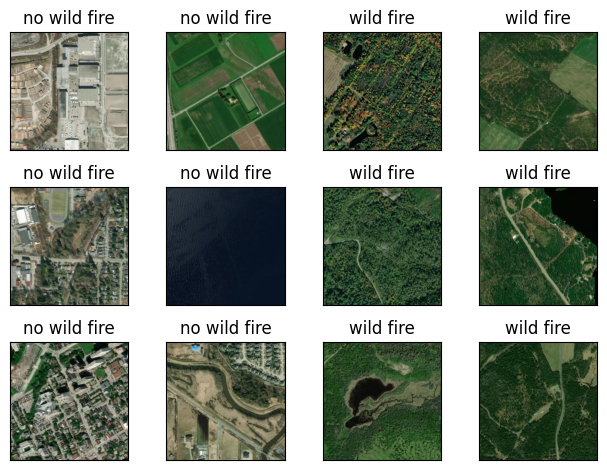

In [ ]:
indices = np.concatenate(
    (torch.where(t_labels == 0)[0][:6], torch.where(t_labels == 1)[0][:6]))

# Show 6 images of each class
show_images(t_images[indices], t_labels[indices], nrows=3, ncols=4)

## Training the model

In [8]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(channels_conv0, channels_conv1, kernel_size_conv1)
        self.conv2 = nn.Conv2d(channels_conv1, channels_conv2, kernel_size_conv2)

        self.fc1 = nn.Linear(num_features0, num_features1)
        self.fc2 = nn.Linear(num_features1, num_features2)
        self.fc3 = nn.Linear(num_features2, 1)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        X = input / 255.0

        # Convolutional block 1
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, (2, 2))

        # Convolutional block 2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, (2, 2))

        # Dense block
        X = torch.flatten(X, 1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        output = F.sigmoid(self.fc3(X))

        return output

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
model.to(device)

optim = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay)

criterion = torch.nn.BCELoss(reduction="sum")
criterion.to(device)

print(f"Using device: {BLUE}{str(device).upper()}{NORMAL}")

Using device: CUDA:0


In [10]:
def train(
        model: Net,
        loader: torch.utils.data.DataLoader,
        optim: torch.optim.Optimizer,
        criterion: torch.nn.Module,
        device: torch.device,
        verbose: bool = False
    ) -> Tuple[float, float]:

    model.train()

    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for step, batch_data in enumerate(loader):
        optim.zero_grad()

        # Get images and labels
        images = batch_data[0].type(torch.float32).to(device)
        labels = batch_data[1].type(torch.float32).to(device)

        # Forward propagation
        outputs = model(images).squeeze()

        # Loss computation
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optim.step()

        epoch_loss += loss.item()
        epoch_accuracy += (outputs.round() == labels).sum().item()

        if verbose:
            header = f"{GREEN}[Step: {step+1}/{len(loader)}]{NORMAL}"
            print(f"\r{header} Batch avg loss: {loss.item() / len(batch_data):.4f}", end="")

    if verbose:
        print("\r", end="")

    return epoch_loss / len(loader.dataset), epoch_accuracy / len(loader.dataset)


def validate(
        model: Net,
        loader: torch.utils.data.DataLoader,
        criterion: torch.nn.Module,
        device: torch.device,
        verbose: bool = False
    ) -> Tuple[float, float]:

    model.eval()

    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for step, batch_data in enumerate(loader):
        # Get images and labels
        images = batch_data[0].type(torch.float32).to(device)
        labels = batch_data[1].type(torch.float32).to(device)

        with torch.no_grad():
            # Forward propagation
            outputs = model(images).squeeze()

            # Loss computation
            loss = criterion(outputs, labels)

        epoch_loss += loss.item()
        epoch_accuracy += (outputs.round() == labels).sum().item()

        if verbose:
            header = f"{GREEN}[Step: {step+1}/{len(loader)}]{NORMAL}"
            print(f"\r{header} Batch avg loss: {loss.item() / len(batch_data):.4f}", end="")

    if verbose:
        print("\r", end="")

    return epoch_loss / len(loader.dataset), epoch_accuracy / len(loader.dataset)

In [11]:
t_history = []
v_history = []

best_loss = float("inf")

for epoch in range(num_epochs):
    header = f"{BLUE}[Epoch: {epoch+1}/{num_epochs}]{NORMAL}"

    print(f"{header} Training")
    t_loss, t_accuracy = train(model, t_loader, optim, criterion, device, verbose=True)
    print(f"{header} Avg loss: {t_loss:.4f} | Accuracy: {t_accuracy:.4f}")

    t_history.append((t_loss, t_accuracy))
    with open("t_history.pickle", "wb") as handle:
        pickle.dump(t_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if (epoch+1) % 1 == 0:
        print(f"{header} Validation")
        v_loss, v_accuracy = validate(model, v_loader, criterion, device, verbose=True)
        print(f"{header} Avg loss: {v_loss:.4f} | Accuracy: {v_accuracy:.4f}")

        v_history.append((v_loss, v_accuracy))
        with open("v_history.pickle", "wb") as handle:
            pickle.dump(v_history, handle, protocol=pickle.HIGHEST_PROTOCOL)

        if v_loss < best_loss:
            best_loss = v_loss
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optim.state_dict(),
                "best_loss": v_loss
            }, "model.pth")

            print(f"\n{GREEN}Best model so far. Saving model as model.pth{NORMAL}\n")

[Epoch: 1/10] Training
[Epoch: 1/10] Avg loss: 0.7906 | Accuracy: 0.6190
[Epoch: 1/10] Validation
[Epoch: 1/10] Avg loss: 0.3653 | Accuracy: 0.8714

Best model so far. Saving model as model.pth

[Epoch: 2/10] Training
[Epoch: 2/10] Avg loss: 0.3074 | Accuracy: 0.8794
[Epoch: 2/10] Validation
[Epoch: 2/10] Avg loss: 0.3530 | Accuracy: 0.8527

Best model so far. Saving model as model.pth

[Epoch: 3/10] Training
[Epoch: 3/10] Avg loss: 0.2981 | Accuracy: 0.8841
[Epoch: 3/10] Validation
[Epoch: 3/10] Avg loss: 0.2396 | Accuracy: 0.9081

Best model so far. Saving model as model.pth

[Epoch: 4/10] Training
[Epoch: 4/10] Avg loss: 0.2761 | Accuracy: 0.8889
[Epoch: 4/10] Validation
[Epoch: 4/10] Avg loss: 0.2470 | Accuracy: 0.9060
[Epoch: 5/10] Training
[Epoch: 5/10] Avg loss: 0.1943 | Accuracy: 0.9333
[Epoch: 5/10] Validation
[Epoch: 5/10] Avg loss: 0.2742 | Accuracy: 0.8875
[Epoch: 6/10] Training
[Epoch: 6/10] Avg loss: 0.1785 | Accuracy: 0.9381
[Epoch: 6/10] Validation
[Epoch: 6/10] Avg los

In [12]:
def plot_history(
        t_history: List[Tuple[float, float]],
        v_history: List[Tuple[float, float]]
    ) -> None:

    x = np.arange(1, len(t_history) + 1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    for i in range(2):
        metric = "loss" if i == 0 else "accuracy"

        t_y = [item[i] for item in t_history]
        v_y = [item[i] for item in v_history]

        axs[i].plot(x, t_y, color="#3772FF", label=f"Training {metric}", linewidth=2)
        axs[i].plot(x, v_y, color="#DF2935", label=f"Validation {metric}", linewidth=2)

        axs[i].grid(color="#C0C0C0", linestyle="dashed")
        axs[i].set_title(f"Evolution of the training and validation {metric}")
        axs[i].set_xlabel("Epoch")
        axs[i].set_ylabel(metric.title())

        axs[i].legend()

    plt.tight_layout()
    plt.show()

    del fig, axs

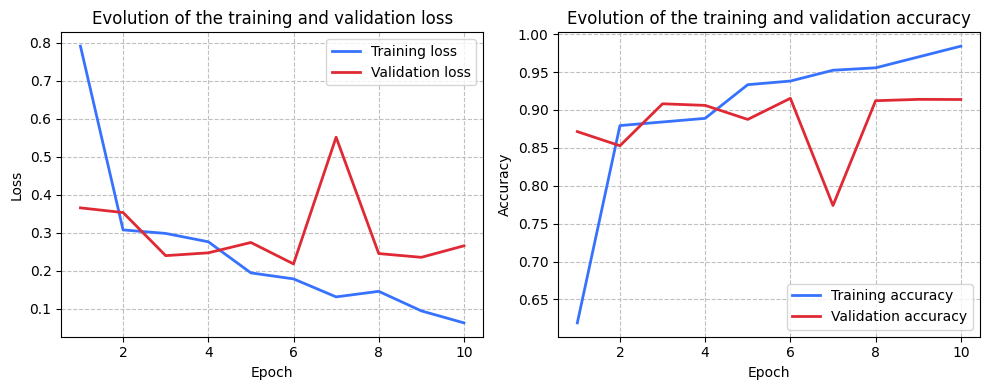

In [13]:
plot_history(t_history, v_history)

## Testing

In [14]:
images, labels = load_data("test", include_labels=True)

loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(images, labels),
    batch_size=32,
    num_workers=2
)

Premature end of JPEG file


In [15]:
print(f"{BLUE}Loading best parameters{NORMAL}")
model = Net()
model.load_state_dict(
    torch.load("model.pth", weights_only=False)["model_state_dict"])
model = model.to(device)
print("Complete\n")

print(f"{BLUE}Testing{NORMAL}")
loss, accuracy = validate(model, loader, criterion, device, verbose=True)
print(f"Avg loss: {loss:.4f} | Accuracy: {accuracy:.4f}")

Loading best parameters
Complete

Testing
Avg loss: 0.2193 | Accuracy: 0.9194loss: 2.59151


Predicted: 1 | Groundtruth: 1
Predicted: 0 | Groundtruth: 1
Predicted: 1 | Groundtruth: 1
Predicted: 1 | Groundtruth: 1
Predicted: 1 | Groundtruth: 1
Predicted: 1 | Groundtruth: 1
Predicted: 1 | Groundtruth: 1
Predicted: 1 | Groundtruth: 1
Predicted: 1 | Groundtruth: 1
Predicted: 1 | Groundtruth: 1
Predicted: 0 | Groundtruth: 0
Predicted: 0 | Groundtruth: 0



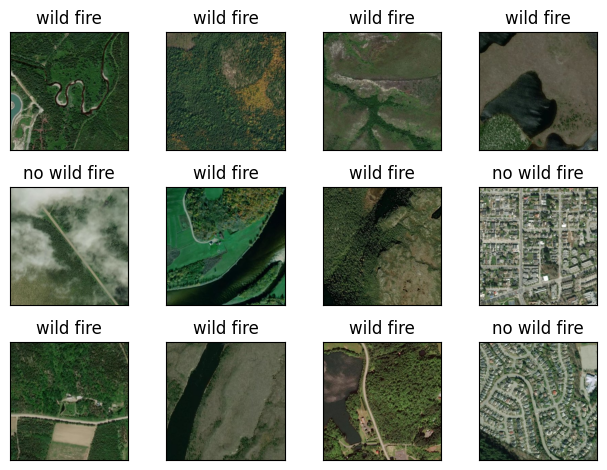

In [16]:
indices = np.random.choice(len(images), size=12, replace=False)

outputs = model(images[indices].to(device))
outputs = outputs.squeeze().round().cpu().detach().numpy().astype(np.uint8)

for i, j in enumerate(indices):
    color = GREEN if outputs[i] == labels[j] else RED
    print(f"Predicted: {color}{outputs[i]}{NORMAL} | Groundtruth: {color}{labels[j]}{NORMAL}")

print()  # Skip line
show_images(images[indices], outputs, nrows=3, ncols=4)

## Conclusion

The implemented model achieved an accuracy of 93% on the unseen test dataset, which was loaded only after the training phase was completed.